# Continuous Bag-Of-Words implementation for Word Embeddings (word2vec)

Using TensorFlow, implement a word embedding layer based on WikiPedia dataset to create word embeddings.

The dataset you will be using is a 'benchmark' dataset for NLP tasks, available from NLP-progress database. The dataset **Text8** is an 'XML dump' of separated words from archived WikiPedia documents, from March 2006, and retains only the text that you would have read on a Wikipedia page. Each document is treated as one long sequence of words, i.e. already 'tokenized', and consists of only lowercase English characters and spaces (no punctuation).

In order to download the dataset, you need to import Gensim module `gensim.downloader`, which is an API for downloading datasets for language modeling exercises (there are two other datasets available). It is a technically a 'dataset' datatype but it can be treated as an iterable (just like a list of lists).

In [1]:
import gensim.downloader as api

In [2]:
dataset = api.load("text8")

In [3]:
type(dataset)

text8.Dataset

## Explore the data

**The only important thing to know about the dataset is that it is an iterable, so you can loop through it.**

In [4]:
# How many documents in dataset?

i = 0

for x in dataset:
    i += 1 
    
print(i)

1701


In [5]:
# Print out first tokenized document to view

i = 0

for x in dataset:
    print(x) 
    i += 1 
    if i > 1:
        break

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst', 'the', 'term', 'is', 'still', 'used', 'in', 'a', 'pejorative', 'way', 'to', 'describe', 'any', 'act', 'that', 'used', 'violent', 'means', 'to', 'destroy', 'the', 'organization', 'of', 'society', 'it', 'has', 'also', 'been', 'taken', 'up', 'as', 'a', 'positive', 'label', 'by', 'self', 'defined', 'anarchists', 'the', 'word', 'anarchism', 'is', 'derived', 'from', 'the', 'greek', 'without', 'archons', 'ruler', 'chief', 'king', 'anarchism', 'as', 'a', 'political', 'philosophy', 'is', 'the', 'belief', 'that', 'rulers', 'are', 'unnecessary', 'and', 'should', 'be', 'abolished', 'although', 'there', 'are', 'differing', 'interpretations', 'of', 'what', 'this', 'means', 'anarchism', 'also', 'refers', 'to', 'related', 'so

In [6]:
# Store length of each document

doc_lengths = []

for x in dataset:
    l = len(x) 
    doc_lengths.append(l)

In [7]:
# Hmmm...are all the documents the same length!

doc_lengths[:5]

[10000, 10000, 10000, 10000, 10000]

In [8]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

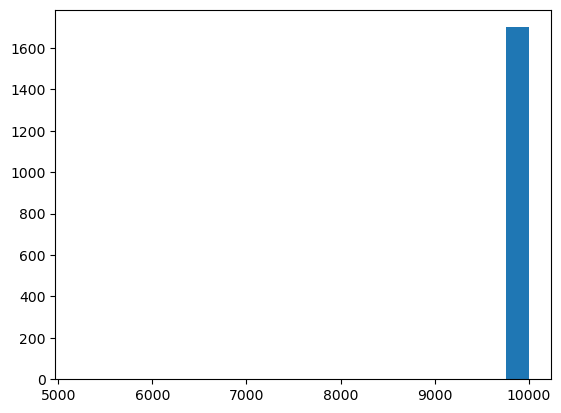

In [9]:
# Plot distribution of document length 

plt.hist(doc_lengths, bins=20);

**The majority of documents in the dataset have the same sequence length (10,000 words). Also, there seems to be a few documents sized arounnd 5000 words, which are hard to see on the plot but the x-axis has obviously covered for them.**

In [10]:
print("Average doc length:", round(np.mean(doc_lengths), 2), "words")

print("Standard deviation:", round(np.std(doc_lengths), 2), "words")

Average doc length: 9997.18 words
Standard deviation: 116.18 words


## Build word-to-index / index-to-word mapping

**Even though the dataset is already sequences of tokenized words, use the TensorFlow tokenizer on the dataset to convert to sequences of integers and generate the word-to-index and index-to-word mappings.**

**Remember to set an appropriate maximum number of words in the vocabulary, e.g. 20,000.**

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

In [12]:
# Set max no of words
vocab_size = 20_000

# Train tokenizer on 20,000 most frequent words in dataset
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(dataset)

In [13]:
# Transform dataset to list of lists of integers

sequences = tokenizer.texts_to_sequences(dataset)

In [14]:
type(sequences)

list

In [15]:
type(sequences[0])

list

In [16]:
type(sequences[0][0])

int

In [17]:
# 1st integer word of 1st document

sequences[0][0]

5234

In [18]:
# Number of documents

len(sequences)

1701

In [19]:
# Length of 1st document (9,538 words)

len(sequences[0])

9538

In [20]:
# No of words tokenizer can take

tokenizer.num_words

20000

In [21]:
# Tokenizer generates word-to-index mapping

tokenizer.word_index['anarchism']

5234

In [22]:
# 253,854 words - mappings keep all words encountered, not just those kept by the tokenizer

len(tokenizer.word_index)

253854

In [23]:
# Tokenizer generates index-to-word mapping (same length)

tokenizer.index_word[2000]

'michigan'

In [24]:
tokenizer.index_word[5234]

'anarchism'

## Build the language model

**Insert a `Lambda` layer as a 'hidden layer' in the classification language model, after the embedding layer.**

In [25]:
from tensorflow.keras.layers import Dense, Input, Embedding, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [26]:
# To replicate results
import random

random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

In [27]:
# Total no of surrounding words (5 on either side)
context_size = 10

# Output embedding dimensions
embedding_dim = 50

In [28]:
# Inner layer
i = Input(shape=(context_size,))

# Embedding layer
x = Embedding(vocab_size, embedding_dim)(i)

# Lambda layer - allows you to use function in network layers
# Reduce mean along axis 1
x = Lambda(lambda t: tf.reduce_mean(t, axis=1))(x)

# Outer layer - make sure not to use bias
x = Dense(vocab_size, use_bias=False)(x)

# Set up model with inputs and outputs
model = Model(i, x)

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 embedding (Embedding)       (None, 10, 50)            1000000   
                                                                 
 lambda (Lambda)             (None, 50)                0         
                                                                 
 dense (Dense)               (None, 20000)             1000000   
                                                                 
Total params: 2,000,000
Trainable params: 2,000,000
Non-trainable params: 0
_________________________________________________________________


**The embedding layer has 1 million 'weights', since the embedding layer inputs 20000 (number of words) and outputs embedding dimensions of fifty per word (20,000 x 50 = 1,000,000), so the embedding layer has the shape 20000-by-50. The final Dense layer has the shape 50-by-20000, so it is a weight matrix of opposite size.** 

**Note there is no bias parameter in outer layer.**

## Build Data Generator

In [30]:
# Set half the context size to help build the context window 
half_context_size = context_size // 2

# Function takes in list of sequences with pre-defined batch size 

def data_generator(sequences, batch_size=128):
    # Pre-allocate arrays that will be populated
    X_batch = np.zeros((batch_size, context_size)) 
    Y_batch = np.zeros(batch_size) 
    
    # Compute no of batches as no of sequences divided by batch size
    n_batches = int(np.ceil(len(sequences) / batch_size)) 
    
    # Enter infinite loop
    while True:
        random.shuffle(sequences) 
        
        # Loop through batches, where one epoch is one pass through each sample
        # For each sample, choose single context window
        for i in range(n_batches):
            # Grab relevant sequences of current batch
            batch_sequences = sequences[i * batch_size:(i + 1) * batch_size] 
            # Compute size of current batch - may be less than batch_size therefore at final batch
            current_batch_size = len(batch_sequences) 
            
            # Loop through each sequence in current batch
            for ii in range(current_batch_size):
                # Grab current sequence
                seq = batch_sequences[ii] 
                # Choose random position in sequence (make space for the context window)
                j = np.random.randint(0, len(seq) - context_size - 1) 
                # Select the context window - x1 is left side and x2 is right side
                x1 = seq[j:j + half_context_size] 
                x2 = seq[j + half_context_size + 1:j + context_size + 1] 
                # Populate X_batch with concatenated context window
                X_batch[ii, :half_context_size] = x1 
                X_batch[ii, half_context_size:] = x2 
                # Populate Y_batch with target, i.e. middle word
                y = seq[j + half_context_size] 
                Y_batch[ii] = y 
                
            # Yield X_batch and Y_batch up to the current batch size
            yield X_batch[:current_batch_size], Y_batch[:current_batch_size]

In [31]:
# Compile neural network as if multi-class classification model

model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])

In [32]:
# NOTE: Training the language model takes about 46 mins!

batch_size = 128

r = model.fit(data_generator(sequences, batch_size), 
              epochs=10000, 
              steps_per_epoch=int(np.ceil(len(sequences) / batch_size)))

Epoch 1/10000
14/14 [==============================] - 2s 58ms/step - loss: 9.9031 - accuracy: 0.0112
Epoch 2/10000
14/14 [==============================] - 1s 57ms/step - loss: 9.9014 - accuracy: 0.0705
Epoch 3/10000
14/14 [==============================] - 1s 56ms/step - loss: 9.8953 - accuracy: 0.0735
Epoch 4/10000
14/14 [==============================] - 1s 62ms/step - loss: 9.8788 - accuracy: 0.0676
Epoch 5/10000
14/14 [==============================] - 1s 60ms/step - loss: 9.8450 - accuracy: 0.0788
Epoch 6/10000
14/14 [==============================] - 1s 74ms/step - loss: 9.7840 - accuracy: 0.0717
Epoch 7/10000
14/14 [==============================] - 1s 55ms/step - loss: 9.6941 - accuracy: 0.0653
Epoch 8/10000
14/14 [==============================] - 1s 61ms/step - loss: 9.5955 - accuracy: 0.0600
Epoch 9/10000
14/14 [==============================] - 1s 67ms/step - loss: 9.4291 - accuracy: 0.0817
Epoch 10/10000
14/14 [==============================] - 1s 81ms/step - loss: 9.246

14/14 [==============================] - 1s 53ms/step - loss: 6.9525 - accuracy: 0.0752
Epoch 160/10000
14/14 [==============================] - 1s 53ms/step - loss: 6.9040 - accuracy: 0.0805
Epoch 161/10000
14/14 [==============================] - 1s 53ms/step - loss: 6.9948 - accuracy: 0.0782
Epoch 162/10000
14/14 [==============================] - 1s 56ms/step - loss: 6.9403 - accuracy: 0.0758
Epoch 163/10000
14/14 [==============================] - 1s 53ms/step - loss: 7.0956 - accuracy: 0.0723
Epoch 164/10000
14/14 [==============================] - 1s 52ms/step - loss: 6.9328 - accuracy: 0.0835
Epoch 165/10000
14/14 [==============================] - 1s 54ms/step - loss: 7.0062 - accuracy: 0.0635
Epoch 166/10000
14/14 [==============================] - 1s 56ms/step - loss: 6.9877 - accuracy: 0.0817
Epoch 167/10000
14/14 [==============================] - 1s 52ms/step - loss: 7.0510 - accuracy: 0.0641
Epoch 168/10000
14/14 [==============================] - 1s 53ms/step - loss: 6.

14/14 [==============================] - 1s 56ms/step - loss: 6.7539 - accuracy: 0.0870
Epoch 316/10000
14/14 [==============================] - 1s 56ms/step - loss: 6.9061 - accuracy: 0.0782
Epoch 317/10000
14/14 [==============================] - 1s 56ms/step - loss: 6.7708 - accuracy: 0.0858
Epoch 318/10000
14/14 [==============================] - 1s 55ms/step - loss: 6.9512 - accuracy: 0.0847
Epoch 319/10000
14/14 [==============================] - 1s 57ms/step - loss: 6.8185 - accuracy: 0.0835
Epoch 320/10000
14/14 [==============================] - 1s 56ms/step - loss: 6.9165 - accuracy: 0.0770
Epoch 321/10000
14/14 [==============================] - 1s 57ms/step - loss: 6.7489 - accuracy: 0.1035
Epoch 322/10000
14/14 [==============================] - 1s 53ms/step - loss: 6.6912 - accuracy: 0.0964
Epoch 323/10000
14/14 [==============================] - 1s 54ms/step - loss: 6.8976 - accuracy: 0.0817
Epoch 324/10000
14/14 [==============================] - 1s 53ms/step - loss: 6.

14/14 [==============================] - 1s 52ms/step - loss: 6.8584 - accuracy: 0.0858
Epoch 472/10000
14/14 [==============================] - 1s 53ms/step - loss: 6.6762 - accuracy: 0.0964
Epoch 473/10000
14/14 [==============================] - 1s 52ms/step - loss: 6.7525 - accuracy: 0.0917
Epoch 474/10000
14/14 [==============================] - 1s 53ms/step - loss: 6.8309 - accuracy: 0.1035
Epoch 475/10000
14/14 [==============================] - 1s 52ms/step - loss: 6.7709 - accuracy: 0.0982
Epoch 476/10000
14/14 [==============================] - 1s 52ms/step - loss: 6.9326 - accuracy: 0.0882
Epoch 477/10000
14/14 [==============================] - 1s 52ms/step - loss: 6.8482 - accuracy: 0.0864
Epoch 478/10000
14/14 [==============================] - 1s 52ms/step - loss: 6.6683 - accuracy: 0.1058
Epoch 479/10000
14/14 [==============================] - 1s 53ms/step - loss: 6.7796 - accuracy: 0.1070
Epoch 480/10000
14/14 [==============================] - 1s 53ms/step - loss: 6.

14/14 [==============================] - 1s 54ms/step - loss: 6.7987 - accuracy: 0.0882
Epoch 628/10000
14/14 [==============================] - 1s 53ms/step - loss: 6.8391 - accuracy: 0.1064
Epoch 629/10000
14/14 [==============================] - 1s 53ms/step - loss: 6.8000 - accuracy: 0.0864
Epoch 630/10000
14/14 [==============================] - 1s 55ms/step - loss: 6.7863 - accuracy: 0.1052
Epoch 631/10000
14/14 [==============================] - 1s 56ms/step - loss: 6.6397 - accuracy: 0.1041
Epoch 632/10000
14/14 [==============================] - 1s 55ms/step - loss: 6.7916 - accuracy: 0.1041
Epoch 633/10000
14/14 [==============================] - 1s 55ms/step - loss: 6.7901 - accuracy: 0.1058
Epoch 634/10000
14/14 [==============================] - 1s 56ms/step - loss: 6.8728 - accuracy: 0.0899
Epoch 635/10000
14/14 [==============================] - 1s 58ms/step - loss: 6.7625 - accuracy: 0.1064
Epoch 636/10000
14/14 [==============================] - 1s 57ms/step - loss: 6.

14/14 [==============================] - 1s 55ms/step - loss: 6.7267 - accuracy: 0.1135
Epoch 784/10000
14/14 [==============================] - 1s 55ms/step - loss: 6.7816 - accuracy: 0.1011
Epoch 785/10000
14/14 [==============================] - 1s 53ms/step - loss: 6.6795 - accuracy: 0.1152
Epoch 786/10000
14/14 [==============================] - 1s 53ms/step - loss: 6.6701 - accuracy: 0.0982
Epoch 787/10000
14/14 [==============================] - 1s 53ms/step - loss: 6.8014 - accuracy: 0.0976
Epoch 788/10000
14/14 [==============================] - 1s 54ms/step - loss: 6.7159 - accuracy: 0.1035
Epoch 789/10000
14/14 [==============================] - 1s 53ms/step - loss: 6.8326 - accuracy: 0.0988
Epoch 790/10000
14/14 [==============================] - 1s 52ms/step - loss: 6.8406 - accuracy: 0.0941
Epoch 791/10000
14/14 [==============================] - 1s 53ms/step - loss: 6.7650 - accuracy: 0.1005
Epoch 792/10000
14/14 [==============================] - 1s 53ms/step - loss: 6.

14/14 [==============================] - 1s 53ms/step - loss: 6.6900 - accuracy: 0.1099
Epoch 940/10000
14/14 [==============================] - 1s 53ms/step - loss: 6.6608 - accuracy: 0.1129
Epoch 941/10000
14/14 [==============================] - 1s 53ms/step - loss: 6.7222 - accuracy: 0.1046
Epoch 942/10000
14/14 [==============================] - 1s 53ms/step - loss: 6.6888 - accuracy: 0.1052
Epoch 943/10000
14/14 [==============================] - 1s 53ms/step - loss: 6.7333 - accuracy: 0.1064
Epoch 944/10000
14/14 [==============================] - 1s 55ms/step - loss: 6.5835 - accuracy: 0.1052
Epoch 945/10000
14/14 [==============================] - 1s 57ms/step - loss: 6.6267 - accuracy: 0.1105
Epoch 946/10000
14/14 [==============================] - 1s 56ms/step - loss: 6.6314 - accuracy: 0.0952
Epoch 947/10000
14/14 [==============================] - 1s 55ms/step - loss: 6.8703 - accuracy: 0.0935
Epoch 948/10000
14/14 [==============================] - 1s 55ms/step - loss: 6.

14/14 [==============================] - 1s 54ms/step - loss: 6.6447 - accuracy: 0.0964
Epoch 1096/10000
14/14 [==============================] - 1s 61ms/step - loss: 6.6703 - accuracy: 0.0905
Epoch 1097/10000
14/14 [==============================] - 1s 59ms/step - loss: 6.7216 - accuracy: 0.1123
Epoch 1098/10000
14/14 [==============================] - 1s 55ms/step - loss: 6.7581 - accuracy: 0.1017
Epoch 1099/10000
14/14 [==============================] - 1s 50ms/step - loss: 6.8094 - accuracy: 0.0905
Epoch 1100/10000
14/14 [==============================] - 1s 71ms/step - loss: 6.6406 - accuracy: 0.0970
Epoch 1101/10000
14/14 [==============================] - 1s 58ms/step - loss: 6.6020 - accuracy: 0.1111
Epoch 1102/10000
14/14 [==============================] - 1s 54ms/step - loss: 6.7064 - accuracy: 0.1005
Epoch 1103/10000
14/14 [==============================] - 1s 50ms/step - loss: 6.6237 - accuracy: 0.1123
Epoch 1104/10000
14/14 [==============================] - 1s 50ms/step -

14/14 [==============================] - 1s 49ms/step - loss: 6.6299 - accuracy: 0.1205
Epoch 1252/10000
14/14 [==============================] - 1s 47ms/step - loss: 6.5966 - accuracy: 0.1188
Epoch 1253/10000
14/14 [==============================] - 1s 49ms/step - loss: 6.6541 - accuracy: 0.1023
Epoch 1254/10000
14/14 [==============================] - 1s 49ms/step - loss: 6.7923 - accuracy: 0.0999
Epoch 1255/10000
14/14 [==============================] - 1s 49ms/step - loss: 6.6844 - accuracy: 0.1129
Epoch 1256/10000
14/14 [==============================] - 1s 48ms/step - loss: 6.5160 - accuracy: 0.1199
Epoch 1257/10000
14/14 [==============================] - 1s 49ms/step - loss: 6.4934 - accuracy: 0.1041
Epoch 1258/10000
14/14 [==============================] - 1s 49ms/step - loss: 6.6798 - accuracy: 0.1099
Epoch 1259/10000
14/14 [==============================] - 1s 49ms/step - loss: 6.6488 - accuracy: 0.0970
Epoch 1260/10000
14/14 [==============================] - 1s 48ms/step -

14/14 [==============================] - 1s 55ms/step - loss: 6.4321 - accuracy: 0.1199
Epoch 1408/10000
14/14 [==============================] - 1s 55ms/step - loss: 6.4855 - accuracy: 0.0947
Epoch 1409/10000
14/14 [==============================] - 1s 55ms/step - loss: 6.5574 - accuracy: 0.0970
Epoch 1410/10000
14/14 [==============================] - 1s 55ms/step - loss: 6.6218 - accuracy: 0.0952
Epoch 1411/10000
14/14 [==============================] - 1s 54ms/step - loss: 6.6121 - accuracy: 0.1093
Epoch 1412/10000
14/14 [==============================] - 1s 55ms/step - loss: 6.5362 - accuracy: 0.1105
Epoch 1413/10000
14/14 [==============================] - 1s 54ms/step - loss: 6.6582 - accuracy: 0.1093
Epoch 1414/10000
14/14 [==============================] - 1s 55ms/step - loss: 6.6526 - accuracy: 0.1129
Epoch 1415/10000
14/14 [==============================] - 1s 55ms/step - loss: 6.6474 - accuracy: 0.1082
Epoch 1416/10000
14/14 [==============================] - 1s 54ms/step -

14/14 [==============================] - 1s 52ms/step - loss: 6.5673 - accuracy: 0.1023
Epoch 1564/10000
14/14 [==============================] - 1s 53ms/step - loss: 6.5991 - accuracy: 0.0999
Epoch 1565/10000
14/14 [==============================] - 1s 52ms/step - loss: 6.5374 - accuracy: 0.1111
Epoch 1566/10000
14/14 [==============================] - 1s 51ms/step - loss: 6.6190 - accuracy: 0.0899
Epoch 1567/10000
14/14 [==============================] - 1s 52ms/step - loss: 6.6049 - accuracy: 0.0994
Epoch 1568/10000
14/14 [==============================] - 1s 52ms/step - loss: 6.5746 - accuracy: 0.1111
Epoch 1569/10000
14/14 [==============================] - 1s 52ms/step - loss: 6.5102 - accuracy: 0.1088
Epoch 1570/10000
14/14 [==============================] - 1s 54ms/step - loss: 6.5222 - accuracy: 0.1152
Epoch 1571/10000
14/14 [==============================] - 1s 59ms/step - loss: 6.6279 - accuracy: 0.0999
Epoch 1572/10000
14/14 [==============================] - 1s 71ms/step -

14/14 [==============================] - 1s 59ms/step - loss: 6.5268 - accuracy: 0.1105
Epoch 1720/10000
14/14 [==============================] - 1s 54ms/step - loss: 6.4902 - accuracy: 0.1023
Epoch 1721/10000
14/14 [==============================] - 1s 56ms/step - loss: 6.4905 - accuracy: 0.0976
Epoch 1722/10000
14/14 [==============================] - 1s 56ms/step - loss: 6.5173 - accuracy: 0.1035
Epoch 1723/10000
14/14 [==============================] - 1s 54ms/step - loss: 6.4888 - accuracy: 0.1146
Epoch 1724/10000
14/14 [==============================] - 1s 55ms/step - loss: 6.4382 - accuracy: 0.1170
Epoch 1725/10000
14/14 [==============================] - 1s 55ms/step - loss: 6.4798 - accuracy: 0.1188
Epoch 1726/10000
14/14 [==============================] - 1s 57ms/step - loss: 6.5089 - accuracy: 0.1199
Epoch 1727/10000
14/14 [==============================] - 1s 59ms/step - loss: 6.6151 - accuracy: 0.1129
Epoch 1728/10000
14/14 [==============================] - 1s 58ms/step -

14/14 [==============================] - 1s 60ms/step - loss: 6.3852 - accuracy: 0.1123
Epoch 1876/10000
14/14 [==============================] - 1s 60ms/step - loss: 6.5275 - accuracy: 0.1058
Epoch 1877/10000
14/14 [==============================] - 1s 61ms/step - loss: 6.4783 - accuracy: 0.1193
Epoch 1878/10000
14/14 [==============================] - 1s 64ms/step - loss: 6.5011 - accuracy: 0.1105
Epoch 1879/10000
14/14 [==============================] - 1s 70ms/step - loss: 6.5015 - accuracy: 0.1141
Epoch 1880/10000
14/14 [==============================] - 1s 63ms/step - loss: 6.4948 - accuracy: 0.1141
Epoch 1881/10000
14/14 [==============================] - 1s 59ms/step - loss: 6.5001 - accuracy: 0.1182
Epoch 1882/10000
14/14 [==============================] - 1s 66ms/step - loss: 6.5634 - accuracy: 0.1093
Epoch 1883/10000
14/14 [==============================] - 1s 78ms/step - loss: 6.5571 - accuracy: 0.1035
Epoch 1884/10000
14/14 [==============================] - 1s 62ms/step -

14/14 [==============================] - 1s 60ms/step - loss: 6.5308 - accuracy: 0.1211
Epoch 2032/10000
14/14 [==============================] - 1s 58ms/step - loss: 6.4604 - accuracy: 0.1117
Epoch 2033/10000
14/14 [==============================] - 1s 56ms/step - loss: 6.4261 - accuracy: 0.1058
Epoch 2034/10000
14/14 [==============================] - 1s 58ms/step - loss: 6.5095 - accuracy: 0.1146
Epoch 2035/10000
14/14 [==============================] - 1s 59ms/step - loss: 6.4143 - accuracy: 0.1188
Epoch 2036/10000
14/14 [==============================] - 1s 59ms/step - loss: 6.5387 - accuracy: 0.1105
Epoch 2037/10000
14/14 [==============================] - 1s 67ms/step - loss: 6.3970 - accuracy: 0.1223
Epoch 2038/10000
14/14 [==============================] - 1s 56ms/step - loss: 6.3338 - accuracy: 0.1299
Epoch 2039/10000
14/14 [==============================] - 1s 49ms/step - loss: 6.6359 - accuracy: 0.1041
Epoch 2040/10000
14/14 [==============================] - 1s 54ms/step -

14/14 [==============================] - 1s 61ms/step - loss: 6.5983 - accuracy: 0.1099
Epoch 2188/10000
14/14 [==============================] - 1s 60ms/step - loss: 6.3684 - accuracy: 0.1188
Epoch 2189/10000
14/14 [==============================] - 1s 62ms/step - loss: 6.5319 - accuracy: 0.0988
Epoch 2190/10000
14/14 [==============================] - 1s 58ms/step - loss: 6.4115 - accuracy: 0.1093
Epoch 2191/10000
14/14 [==============================] - 1s 62ms/step - loss: 6.5501 - accuracy: 0.1123
Epoch 2192/10000
14/14 [==============================] - 1s 59ms/step - loss: 6.5047 - accuracy: 0.1123
Epoch 2193/10000
14/14 [==============================] - 1s 65ms/step - loss: 6.4628 - accuracy: 0.1258
Epoch 2194/10000
14/14 [==============================] - 1s 58ms/step - loss: 6.4477 - accuracy: 0.1170
Epoch 2195/10000
14/14 [==============================] - 1s 59ms/step - loss: 6.4294 - accuracy: 0.1235
Epoch 2196/10000
14/14 [==============================] - 1s 71ms/step -

14/14 [==============================] - 1s 68ms/step - loss: 6.5205 - accuracy: 0.1146
Epoch 2344/10000
14/14 [==============================] - 1s 62ms/step - loss: 6.5383 - accuracy: 0.1141
Epoch 2345/10000
14/14 [==============================] - 1s 65ms/step - loss: 6.5514 - accuracy: 0.1105
Epoch 2346/10000
14/14 [==============================] - 1s 65ms/step - loss: 6.4886 - accuracy: 0.1311
Epoch 2347/10000
14/14 [==============================] - 1s 63ms/step - loss: 6.4230 - accuracy: 0.1252
Epoch 2348/10000
14/14 [==============================] - 1s 63ms/step - loss: 6.4964 - accuracy: 0.1317
Epoch 2349/10000
14/14 [==============================] - 1s 71ms/step - loss: 6.4579 - accuracy: 0.1188
Epoch 2350/10000
14/14 [==============================] - 1s 65ms/step - loss: 6.4838 - accuracy: 0.1199
Epoch 2351/10000
14/14 [==============================] - 1s 64ms/step - loss: 6.4781 - accuracy: 0.1129
Epoch 2352/10000
14/14 [==============================] - 1s 54ms/step -

14/14 [==============================] - 1s 56ms/step - loss: 6.3254 - accuracy: 0.1293
Epoch 2500/10000
14/14 [==============================] - 1s 54ms/step - loss: 6.3461 - accuracy: 0.1317
Epoch 2501/10000
14/14 [==============================] - 1s 57ms/step - loss: 6.5330 - accuracy: 0.1005
Epoch 2502/10000
14/14 [==============================] - 1s 58ms/step - loss: 6.4989 - accuracy: 0.1199
Epoch 2503/10000
14/14 [==============================] - 1s 57ms/step - loss: 6.3437 - accuracy: 0.1129
Epoch 2504/10000
14/14 [==============================] - 1s 57ms/step - loss: 6.3715 - accuracy: 0.1235
Epoch 2505/10000
14/14 [==============================] - 1s 52ms/step - loss: 6.3840 - accuracy: 0.1141
Epoch 2506/10000
14/14 [==============================] - 1s 52ms/step - loss: 6.3705 - accuracy: 0.1229
Epoch 2507/10000
14/14 [==============================] - 1s 53ms/step - loss: 6.3994 - accuracy: 0.1364
Epoch 2508/10000
14/14 [==============================] - 1s 57ms/step -

14/14 [==============================] - 1s 58ms/step - loss: 6.4220 - accuracy: 0.1205
Epoch 2656/10000
14/14 [==============================] - 1s 55ms/step - loss: 6.4779 - accuracy: 0.1046
Epoch 2657/10000
14/14 [==============================] - 1s 52ms/step - loss: 6.4710 - accuracy: 0.1117
Epoch 2658/10000
14/14 [==============================] - 1s 57ms/step - loss: 6.3708 - accuracy: 0.1158
Epoch 2659/10000
14/14 [==============================] - 1s 58ms/step - loss: 6.3225 - accuracy: 0.1335
Epoch 2660/10000
14/14 [==============================] - 1s 60ms/step - loss: 6.2664 - accuracy: 0.1323
Epoch 2661/10000
14/14 [==============================] - 1s 57ms/step - loss: 6.4342 - accuracy: 0.1146
Epoch 2662/10000
14/14 [==============================] - 1s 59ms/step - loss: 6.4049 - accuracy: 0.1135
Epoch 2663/10000
14/14 [==============================] - 1s 59ms/step - loss: 6.4282 - accuracy: 0.1235
Epoch 2664/10000
14/14 [==============================] - 1s 58ms/step -

14/14 [==============================] - 1s 51ms/step - loss: 6.2812 - accuracy: 0.1311
Epoch 2812/10000
14/14 [==============================] - 1s 57ms/step - loss: 6.4075 - accuracy: 0.1182
Epoch 2813/10000
14/14 [==============================] - 1s 57ms/step - loss: 6.4111 - accuracy: 0.1246
Epoch 2814/10000
14/14 [==============================] - 1s 65ms/step - loss: 6.5050 - accuracy: 0.1199
Epoch 2815/10000
14/14 [==============================] - 1s 66ms/step - loss: 6.4535 - accuracy: 0.1158
Epoch 2816/10000
14/14 [==============================] - 1s 56ms/step - loss: 6.4922 - accuracy: 0.1070
Epoch 2817/10000
14/14 [==============================] - 1s 52ms/step - loss: 6.3253 - accuracy: 0.1211
Epoch 2818/10000
14/14 [==============================] - 1s 53ms/step - loss: 6.3399 - accuracy: 0.1188
Epoch 2819/10000
14/14 [==============================] - 1s 57ms/step - loss: 6.2892 - accuracy: 0.1176
Epoch 2820/10000
14/14 [==============================] - 1s 57ms/step -

14/14 [==============================] - 1s 57ms/step - loss: 6.3513 - accuracy: 0.1393
Epoch 2968/10000
14/14 [==============================] - 1s 55ms/step - loss: 6.4627 - accuracy: 0.1235
Epoch 2969/10000
14/14 [==============================] - 1s 59ms/step - loss: 6.2834 - accuracy: 0.1311
Epoch 2970/10000
14/14 [==============================] - 1s 60ms/step - loss: 6.4931 - accuracy: 0.1129
Epoch 2971/10000
14/14 [==============================] - 1s 57ms/step - loss: 6.2287 - accuracy: 0.1340
Epoch 2972/10000
14/14 [==============================] - 1s 58ms/step - loss: 6.2331 - accuracy: 0.1264
Epoch 2973/10000
14/14 [==============================] - 1s 53ms/step - loss: 6.2382 - accuracy: 0.1052
Epoch 2974/10000
14/14 [==============================] - 1s 49ms/step - loss: 6.4066 - accuracy: 0.1205
Epoch 2975/10000
14/14 [==============================] - 1s 59ms/step - loss: 6.2569 - accuracy: 0.1317
Epoch 2976/10000
14/14 [==============================] - 1s 58ms/step -

14/14 [==============================] - 1s 56ms/step - loss: 6.3849 - accuracy: 0.1229
Epoch 3124/10000
14/14 [==============================] - 1s 56ms/step - loss: 6.2874 - accuracy: 0.1223
Epoch 3125/10000
14/14 [==============================] - 1s 55ms/step - loss: 6.2193 - accuracy: 0.1240
Epoch 3126/10000
14/14 [==============================] - 1s 54ms/step - loss: 6.4213 - accuracy: 0.1111
Epoch 3127/10000
14/14 [==============================] - 1s 56ms/step - loss: 6.3345 - accuracy: 0.1264
Epoch 3128/10000
14/14 [==============================] - 1s 56ms/step - loss: 6.4707 - accuracy: 0.1205
Epoch 3129/10000
14/14 [==============================] - 1s 54ms/step - loss: 6.3899 - accuracy: 0.1146
Epoch 3130/10000
14/14 [==============================] - 1s 53ms/step - loss: 6.2923 - accuracy: 0.1188
Epoch 3131/10000
14/14 [==============================] - 1s 54ms/step - loss: 6.3349 - accuracy: 0.1276
Epoch 3132/10000
14/14 [==============================] - 1s 53ms/step -

14/14 [==============================] - 1s 57ms/step - loss: 6.4148 - accuracy: 0.1193
Epoch 3280/10000
14/14 [==============================] - 1s 57ms/step - loss: 6.3484 - accuracy: 0.1246
Epoch 3281/10000
14/14 [==============================] - 1s 54ms/step - loss: 6.3546 - accuracy: 0.1211
Epoch 3282/10000
14/14 [==============================] - 1s 53ms/step - loss: 6.3336 - accuracy: 0.1082
Epoch 3283/10000
14/14 [==============================] - 1s 59ms/step - loss: 6.1969 - accuracy: 0.1399
Epoch 3284/10000
14/14 [==============================] - 1s 54ms/step - loss: 6.4163 - accuracy: 0.1340
Epoch 3285/10000
14/14 [==============================] - 1s 54ms/step - loss: 6.4144 - accuracy: 0.1211
Epoch 3286/10000
14/14 [==============================] - 1s 58ms/step - loss: 6.3088 - accuracy: 0.1223
Epoch 3287/10000
14/14 [==============================] - 1s 54ms/step - loss: 6.3672 - accuracy: 0.1129
Epoch 3288/10000
14/14 [==============================] - 1s 57ms/step -

14/14 [==============================] - 1s 58ms/step - loss: 6.3086 - accuracy: 0.1123
Epoch 3436/10000
14/14 [==============================] - 1s 59ms/step - loss: 6.1625 - accuracy: 0.1329
Epoch 3437/10000
14/14 [==============================] - 1s 56ms/step - loss: 6.3954 - accuracy: 0.1205
Epoch 3438/10000
14/14 [==============================] - 1s 56ms/step - loss: 6.3339 - accuracy: 0.1246
Epoch 3439/10000
14/14 [==============================] - 1s 56ms/step - loss: 6.2834 - accuracy: 0.1235
Epoch 3440/10000
14/14 [==============================] - 1s 51ms/step - loss: 6.3664 - accuracy: 0.1152
Epoch 3441/10000
14/14 [==============================] - 1s 52ms/step - loss: 6.3346 - accuracy: 0.1276
Epoch 3442/10000
14/14 [==============================] - 1s 54ms/step - loss: 6.2181 - accuracy: 0.1193
Epoch 3443/10000
14/14 [==============================] - 1s 52ms/step - loss: 6.2774 - accuracy: 0.1164
Epoch 3444/10000
14/14 [==============================] - 1s 54ms/step -

14/14 [==============================] - 1s 65ms/step - loss: 6.2303 - accuracy: 0.1311
Epoch 3592/10000
14/14 [==============================] - 1s 60ms/step - loss: 6.3390 - accuracy: 0.1141
Epoch 3593/10000
14/14 [==============================] - 1s 67ms/step - loss: 6.2757 - accuracy: 0.1305
Epoch 3594/10000
14/14 [==============================] - 1s 70ms/step - loss: 6.3412 - accuracy: 0.1076
Epoch 3595/10000
14/14 [==============================] - 1s 60ms/step - loss: 6.1960 - accuracy: 0.1305
Epoch 3596/10000
14/14 [==============================] - 1s 60ms/step - loss: 6.3622 - accuracy: 0.1358
Epoch 3597/10000
14/14 [==============================] - 1s 55ms/step - loss: 6.2445 - accuracy: 0.1346
Epoch 3598/10000
14/14 [==============================] - 1s 69ms/step - loss: 6.2600 - accuracy: 0.1340
Epoch 3599/10000
14/14 [==============================] - 1s 71ms/step - loss: 6.3321 - accuracy: 0.1229
Epoch 3600/10000
14/14 [==============================] - 1s 62ms/step -

14/14 [==============================] - 1s 53ms/step - loss: 6.3714 - accuracy: 0.1193
Epoch 3748/10000
14/14 [==============================] - 1s 56ms/step - loss: 6.2475 - accuracy: 0.1276
Epoch 3749/10000
14/14 [==============================] - 1s 52ms/step - loss: 6.3207 - accuracy: 0.1305
Epoch 3750/10000
14/14 [==============================] - 1s 52ms/step - loss: 6.3254 - accuracy: 0.1293
Epoch 3751/10000
14/14 [==============================] - 1s 52ms/step - loss: 6.3170 - accuracy: 0.1135
Epoch 3752/10000
14/14 [==============================] - 1s 54ms/step - loss: 6.2515 - accuracy: 0.1335
Epoch 3753/10000
14/14 [==============================] - 1s 54ms/step - loss: 6.3432 - accuracy: 0.1123
Epoch 3754/10000
14/14 [==============================] - 1s 54ms/step - loss: 6.2127 - accuracy: 0.1335
Epoch 3755/10000
14/14 [==============================] - 1s 56ms/step - loss: 6.3221 - accuracy: 0.1293
Epoch 3756/10000
14/14 [==============================] - 1s 53ms/step -

14/14 [==============================] - 1s 51ms/step - loss: 6.1907 - accuracy: 0.1311
Epoch 3904/10000
14/14 [==============================] - 1s 57ms/step - loss: 6.2985 - accuracy: 0.1188
Epoch 3905/10000
14/14 [==============================] - 1s 51ms/step - loss: 6.2512 - accuracy: 0.1240
Epoch 3906/10000
14/14 [==============================] - 1s 57ms/step - loss: 6.2830 - accuracy: 0.1188
Epoch 3907/10000
14/14 [==============================] - 1s 58ms/step - loss: 6.2019 - accuracy: 0.1270
Epoch 3908/10000
14/14 [==============================] - 1s 58ms/step - loss: 6.1183 - accuracy: 0.1329
Epoch 3909/10000
14/14 [==============================] - 1s 56ms/step - loss: 6.1111 - accuracy: 0.1464
Epoch 3910/10000
14/14 [==============================] - 1s 55ms/step - loss: 6.2296 - accuracy: 0.1317
Epoch 3911/10000
14/14 [==============================] - 1s 60ms/step - loss: 6.3576 - accuracy: 0.1164
Epoch 3912/10000
14/14 [==============================] - 1s 62ms/step -

14/14 [==============================] - 1s 51ms/step - loss: 6.3203 - accuracy: 0.1146
Epoch 4060/10000
14/14 [==============================] - 1s 53ms/step - loss: 6.2603 - accuracy: 0.1370
Epoch 4061/10000
14/14 [==============================] - 1s 51ms/step - loss: 6.2799 - accuracy: 0.1352
Epoch 4062/10000
14/14 [==============================] - 1s 53ms/step - loss: 6.1576 - accuracy: 0.1270
Epoch 4063/10000
14/14 [==============================] - 1s 52ms/step - loss: 6.3488 - accuracy: 0.1146
Epoch 4064/10000
14/14 [==============================] - 1s 51ms/step - loss: 6.2106 - accuracy: 0.1176
Epoch 4065/10000
14/14 [==============================] - 1s 51ms/step - loss: 6.2548 - accuracy: 0.1205
Epoch 4066/10000
14/14 [==============================] - 1s 51ms/step - loss: 6.3082 - accuracy: 0.1152
Epoch 4067/10000
14/14 [==============================] - 1s 51ms/step - loss: 6.2755 - accuracy: 0.1252
Epoch 4068/10000
14/14 [==============================] - 1s 52ms/step -

14/14 [==============================] - 1s 61ms/step - loss: 6.1143 - accuracy: 0.1235
Epoch 6375/10000
14/14 [==============================] - 1s 60ms/step - loss: 6.0985 - accuracy: 0.1346
Epoch 6376/10000
14/14 [==============================] - 1s 57ms/step - loss: 6.0664 - accuracy: 0.1364
Epoch 6377/10000
14/14 [==============================] - 1s 56ms/step - loss: 6.2038 - accuracy: 0.1211
Epoch 6378/10000
14/14 [==============================] - 1s 62ms/step - loss: 6.1861 - accuracy: 0.1311
Epoch 6379/10000
14/14 [==============================] - 1s 63ms/step - loss: 6.0327 - accuracy: 0.1352
Epoch 6380/10000
14/14 [==============================] - 1s 59ms/step - loss: 6.0946 - accuracy: 0.1352
Epoch 6381/10000
14/14 [==============================] - 1s 57ms/step - loss: 5.9841 - accuracy: 0.1340
Epoch 6382/10000
14/14 [==============================] - 1s 60ms/step - loss: 6.1564 - accuracy: 0.1299
Epoch 6383/10000
14/14 [==============================] - 1s 60ms/step -

## Plot losses and accuracy per epoch

In [33]:
r.history

{'loss': [9.903121948242188,
  9.901381492614746,
  9.895296096801758,
  9.878776550292969,
  9.845047950744629,
  9.783995628356934,
  9.694062232971191,
  9.595541954040527,
  9.429134368896484,
  9.246187210083008,
  9.097542762756348,
  8.847381591796875,
  8.625070571899414,
  8.465301513671875,
  8.189423561096191,
  7.969398021697998,
  7.675760746002197,
  7.590349197387695,
  7.517437934875488,
  7.369809627532959,
  7.453442096710205,
  7.387073040008545,
  7.314651966094971,
  7.385022163391113,
  7.332189559936523,
  7.320559024810791,
  7.288792133331299,
  7.312860488891602,
  7.259592056274414,
  7.307990550994873,
  7.244973182678223,
  7.314273834228516,
  7.2115797996521,
  7.261381149291992,
  7.130214214324951,
  7.296469688415527,
  7.342936992645264,
  7.333545207977295,
  7.2972612380981445,
  7.175177097320557,
  7.215367794036865,
  7.191107749938965,
  7.167213439941406,
  7.2490763664245605,
  7.226703643798828,
  7.253839492797852,
  7.28818416595459,
  7.17

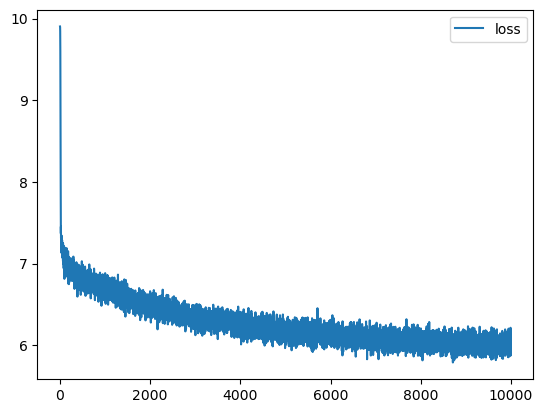

In [34]:
# Plot loss

plt.plot(r.history['loss'], label='loss')
plt.legend();

**Note that loss per epoch is quite stochastic, because predicting a word in a sentence, given other words, has some variation. However, overall, the loss is steadily decreasing which is a good sign.**

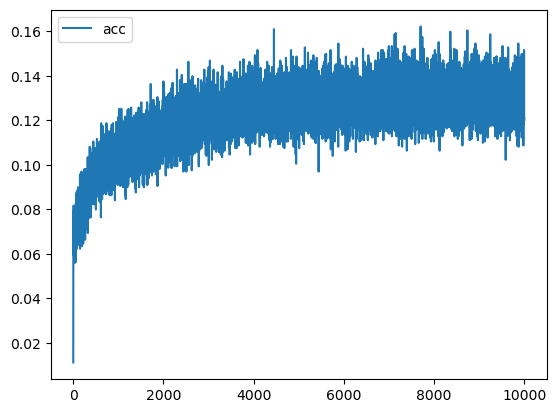

In [35]:
# Plot accuracy

plt.plot(r.history['accuracy'], label='acc')
plt.legend();

**This is mirror image of the plotted losses.**

## Embedding matrix and Nearest Neighbours

**The embedding matrix can be accessed from the model's `layers` (remember to index the first nested array).**

**The Nearest Neighbours algorithm can use distance in depth-first order (`algorithm='ball_tree'`) to find the five closest vectors to the query vector. By training it on the embeddings matrix, you can later pass through a query vector and this model will tell you the five closest-related words by finding their embedding vectors in the matrix.**

In [36]:
embeddings = model.layers[1].get_weights()[0]

embeddings

array([[-0.02410002,  0.03624469,  0.04384006, ...,  0.02396232,
         0.04405816,  0.04269155],
       [ 0.5945231 ,  0.32856685,  0.45130202, ..., -0.23459312,
         0.14026323,  0.40995413],
       [ 0.37326303,  0.8723255 , -0.8188485 , ...,  0.64846087,
         1.0922387 ,  0.00497018],
       ...,
       [ 0.06023063, -0.03624298, -0.3152012 , ..., -0.17168163,
         0.03234242, -0.6450336 ],
       [ 0.09183026,  0.34507897, -0.25751975, ...,  0.0352428 ,
        -0.74487567, -0.1348794 ],
       [ 0.20672269,  0.21169086, -0.54822874, ...,  0.02118726,
         0.07532363, -0.29827604]], dtype=float32)

**Use SciKit-Learn nearest neighbours model on the word embeddings to find the five nearest words to each word**

In [37]:
from sklearn.neighbors import NearestNeighbors

# Use ball tree algorithm searches for neighbours in depth-first order
neighbors = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')

neighbors.fit(embeddings)

NearestNeighbors(algorithm='ball_tree')

**Find the index for the word 'queen' from word-to-index mapping dictionary, then search for it in embeddings matrix to run through the Nearest Neighbours model to grab the five closest embedding vectors and corresponding indices.**

In [38]:
queen_idx = tokenizer.word_index['queen']

queen = embeddings[queen_idx:queen_idx + 1]

distances, indices = neighbors.kneighbors(queen)

indices

array([[ 903, 1061,  187, 2032, 3421]], dtype=int64)

**Loop through the indices and match to the actual words in index-to-word mapping dictionary.**

In [39]:
for idx in indices[0]:
    word = tokenizer.index_word[idx] 
    print(word)

queen
prince
king
elizabeth
princess


### Create function to run word query and output five closest words

**You can contain the two kernels above into one custom function that you can re-run.**

In [40]:
# Function accepts word

def print_neighbors(query):
    query_idx = tokenizer.word_index[query] 
    query = embeddings[query_idx:query_idx + 1] 
    distances, indices = neighbors.kneighbors(query) 
    
    for idx in indices[0]:
        word = tokenizer.index_word[idx] 
        print(word)

In [41]:
print_neighbors('uncle')

uncle
grandfather
nephew
widow
grandmother


In [42]:
print_neighbors('anarchy')

anarchy
zedong
reactionary
loyalist
tito


In [43]:
print_neighbors('japan')

japan
indonesia
pakistan
taiwan
cambodia


In [44]:
print_neighbors('london')

london
minneapolis
toronto
massachusetts
edinburgh


In [45]:
print_neighbors('election')

election
elections
presidential
vote
candidate


**All the results make sense so it looks like the word embeddings worked.**

## Create word analogies

**In this exercise, you want to find the missing word from a word analogy, e.g. `'king' - 'man' = '?' - 'woman'`. We know the missing word is 'queen' but we want to find the answer through the word embeddings.**

**By accessing the embeddings matrix to grab the word vectors for the three words we do have (king, man, woman), you can then re-arrange the above formula in your query when searching for the closest word vectors:**

    queen = king - man + woman

In [46]:
# Function to get word embedding for a queried word

def get_embedding(word):
    idx = tokenizer.word_index[word] 
    return embeddings[idx:idx + 1]

In [47]:
# Word analogy: king - man = 'queen' - woman

# Access word vectors
king = get_embedding('king')
man = get_embedding('man')
woman = get_embedding('woman')

# Create your query
query = king - man + woman

# Run query through Nearest Neighbours
distances, indices = neighbors.kneighbors(query)

# Match closest word vectors to the words
for idx in indices[0]:
    word = tokenizer.index_word[idx] 
    print(word)

king
queen
henry
son
prince


**It is in the closest five words but 'queen' should be at the top.**

**Typically, the words within the query should not have been returned, i.e. king should not be there.**

In [48]:
# Word analogy: england - english = 'australia' - australian

england = get_embedding('england')
english = get_embedding('english')
australian = get_embedding('australian')
query = england - english + australian

distances, indices = neighbors.kneighbors(query)

for idx in indices[0]:
    word = tokenizer.index_word[idx] 
    print(word)

australia
canada
victoria
georgia
mexico


**Success!**

In [ ]:
# EXERCISE: read the word2vec paper, connect it to what we did here